Este trabalho é referente à disciplina de Inteligência Artificial do curso de Bacharelado em Ciência da Computação na Universidade Federal do Pará. Ele propõe a aplicação de uma **árvore de decisão** e de uma **rede neural *feed-forward*** em um conjunto de dados de classificação.

Integrantes:

- [201804940002] Eduardo Gil Serrão Cardoso
- [201804940016] Gabriela Souza Maximino
- [201704940007] Igor Matheus Souza Moreira

Durante todo o ciclo de desenvolvimento deste trabalho, o GitHub foi utilizado como ferramenta de versionamento. O histórico de desenvolvimento da equipe, bem como versões iniciais do código aqui contido, está disponível ao público no GitHub em [@ygarasab/data-classification](https://github.com/ygarasab/data-classification/).

**Observação:** antes de interagir com o código no Jupyter Notebook/Lab, é importante observar que certas células anteriores à que se quer executar podem ser necessárias. A fim de evitar isso, é importante certificar-se de executar ao menos uma vez todas as células contendo definições de funções ou importações de módulos.

# Requisitos

## Ambiente

Este trabalho foi feito utilizando a seguinte linguagem de programação:

- `python` 3.8.6

Em adição, os seguintes módulos precisam estar instalados no ambiente em que este notebook for executado:

- `h5py` 2.10.0
- `matplotlib` 3.3.2
- `numpy` 1.19.4
- `pandas` 1.1.5
- `seaborn` 0.11.0
- `scikit-learn` 0.24.0

In [1]:
import h5py
import numpy as np
import pathlib
import pandas as pd
import seaborn as sns

In [2]:
from matplotlib import pyplot as plt
from sklearn import base, feature_selection, metrics, model_selection, neural_network, tree

## Diretório de resultados

Para fins de referência, vários resultados produzidos neste notebook são armazenados. Dessa forma, caso a pasta não exista, ela deve ser criada, e o caminho absoluto até ela precisa ser definido.

In [3]:
diretorio_de_resultados = pathlib.Path().absolute().parent / "resultados"

if diretorio_de_resultados.exists() is False:
    diretorio_de_resultados.mkdir(exist_ok=True)

# O conjunto de dados

Em aderência ao estipulado nas especificações desta atividade, o [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.html) foi utilizado para a escolha de um conjunto de dados de classificação. Após a análise de alguns conjuntos de dados, escolheu-se o [Dota2 Games Results](https://archive.ics.uci.edu/ml/datasets/Dota2+Games+Results) como o conjunto de dados a ser utilizado para a construção de modelos neste trabalho.

O conjunto de dados está particionado em dois arquivos: `dota2Train.csv` e `dota2Test.csv`. Tem-se alguns problemas aqui:

- O tamanho de um arquivo `.csv` é substancialmente maior do que poderia ser, por exemplo, em um arquivo `.h5`, uma vez que não há compressão nele;
- A divisão feita entre treino e teste foi $90\%$-$10\%$, enquanto que o estipulado para este trabalho é um _Holdout_ $70\%$-$30\%$;
- A variável dependente que queremos predizer está no mesmo arquivo em que as variáveis independentes estão, e precisamos separá-las; e
- Uma breve análise nos arquivos trouxe à tona o fato de que as colunas $27$ e $111$ possuem sempre os mesmos valores, o que não acrescenta informação mas agrava a maldição da dimensionalidade.

A fim de resolver esses pequenos problemas, os arquivos `.csv` precisam ser concatenados, as colunas $27$ e $111$ precisam ser removidas, e o arquivo resultante precisa ser salvo em formato `.h5`. Considerando que o formato `.h5`, aos moldes de um dicionário ou de arquivos `.mat`, nos permite salvar vários objetos em chaves diferentes, salvemos três variáveis:

- `X` (as variáveis independentes);
- `y` (os rótulos de classe); e
- `K` (o número de classes).

In [4]:
# treino = pd.read_csv("../dados/dota2Train.csv", header=None)
# teste = pd.read_csv("../dados/dota2Test.csv", header=None)

In [5]:
# dados = pd.concat((treino, teste))

In [6]:
# X = dados.drop([0, 27, 111], axis=1).to_numpy()
# y = dados.iloc[:, 0].to_numpy()

In [7]:
# with h5py.File("../dados/dota2.h5", "w") as arquivo:
#     arquivo.create_dataset("X", data=X, compression="gzip", compression_opts=9)
#     arquivo.create_dataset("y", data=y, compression="gzip", compression_opts=9)
#     arquivo.create_dataset("K", data=np.unique(y).size)

In [8]:
nomes_das_colunas = (
    ["ID de cluster", "Modo de jogo", "Tipo de jogo"] + 
    [f"Herói {i}" for i in range(26)] + 
    [f"Herói {i}" for i in range(27, 111)] + 
    [f"Herói {i}" for i in range(112, 113)]
)

In [9]:
with h5py.File("../dados/dota2.h5", "r") as arquivo:
    X = pd.DataFrame(arquivo.get("X")[()], columns=nomes_das_colunas)
    y = pd.DataFrame(arquivo.get("y")[()], columns=["Vencedor"])

## Descrição do conjunto de dados

Conforme pode ser adivinhado pelos nomes vistos em `nomes_das_colunas`, este conjunto de dados possui algumas informações de partidas de algum jogo. No caso, o jogo em questão é **_Defense of the Ancients_ (DotA)**. Neste jogo, vários modos e tipos de jogo podem ser escolhidos. Em todos eles, duas equipes compostas por $5$ jogadores batalham entre si. A variável a ser predita é qual dos dois times ganha a partida ($-1$ ou $1$), e como variáveis independentes temos:

- **ID de cluster:** variável categórica que indica a região em que o jogador está jogando;
- **Modo de jogo:** variável categórica. Um exemplo: *all pick*;
- **Tipo de jogo:** variável categórica. Um exemplo: *ranked*; e
- **Herói {0, 1, ..., 111, 112}:** quais dos heróis foram utilizados pelos time:
    - **$-1$:** um time utilizou o herói;
    - **$0$:** nenhum dos times utilizou o herói; e
    - **$1$:** outro time utilizou o herói.
    
A princípio, este conjunto de dados aparenta ser um pouco escasso em características, uma vez que praticamente não descreve características relacionadas ao desempenho dos jogadores no jogo (basicamente, as únicas características que envolvem os jogadores são as dos heróis, que expõem se uma das equipes escolheu um dado herói ou não). Considerando que este é um jogo onde a atuação dos jogadores é absolutamente decisiva em termos de desfecho (e.g., através de acúmulo de ouro, compra de itens, assistências, assassinatos e mortes), tem-se que este conjunto de dados certamente não possui um quadro tão abrangente quanto deveria. Há conjuntos de dados com tais informações, como um visto no [Kaggle](https://www.kaggle.com/c/mlcourse-dota2-win-prediction/). Contudo, em aderência ao estipulado na descrição deste trabalho, este conjunto de dados de partidas de DotA encontrado no _UCI Machine Learning Repository_ foi utilizado.

## Divisão em treino e teste

Antes de passarmos o conjunto de dados pelo _pipeline_ desenvolvido, precisamos realizar o Holdout estratificado $70\%$-$30\%$, conforme o estipulado nas especificações do trabalho.

In [10]:
X_treino, X_teste, y_treino, y_teste = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_treino, X_teste, y_treino, y_teste = X_treino.copy(), X_teste.copy(), y_treino.copy(), y_teste.copy()

# Pré-processamento

Nesta seção, realizaremos a codificação das variáveis categóricas, bem como tentaremos descobrir quais são as características melhor correlacionadas com o rótulo a ser predito. Dessa forma, melhoraremos o conjunto de dados aos olhos dos algoritmos a serem empregados, bem como reduziremos a maldição da dimensionalidade.

## Conversão de variáveis em versões _target-encoded_

In [11]:
class KFoldStratifiedTargetEncoder(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, number_of_folds=5, verbose=False):
        self.number_of_folds = number_of_folds
        self.verbose = verbose

        self._values = None

    @property
    def number_of_folds(self):
        return self.__number_of_folds

    @number_of_folds.setter
    def number_of_folds(self, new_number_of_folds):
        self.__number_of_folds = new_number_of_folds

    @property
    def verbose(self):
        return self.__verbose

    @verbose.setter
    def verbose(self, new_verbose):
        self.__verbose = new_verbose

    def fit(self, X, y, **fit_params):
        encoded_X, current_fold = np.empty_like(X, dtype=np.float_), 0
        stratified_k_fold = model_selection.StratifiedKFold(n_splits=self.number_of_folds)

        for train_indices, test_indices in stratified_k_fold.split(X, y):
            X_train, y_train, X_test = X[train_indices, :], y[train_indices], X[test_indices, :]
            self._values = {column: None for column in range(X.shape[1])}

            for column in range(X.shape[1]):
                X_train_column, X_test_column = X_train[:, column], X_test[:, column]
                encoded_X_column = np.full_like(X_test_column, y_train.mean(), dtype=np.float_)
                categories = np.unique(X_train_column)

                for category in categories:
                    encoded_X_column[X_test_column == category] = y_train[X_train_column == category].mean()
                encoded_X[test_indices, column] = encoded_X_column

            current_fold += 1

        for column in range(X.shape[1]):
            X_column = X[:, column]
            categories = np.unique(X_column)

            self._values[column] = {category: None for category in categories}

            for category in categories:
                self._values[column][category] = y[X_column == category].mean()

        if "return_encoded_X" in fit_params.keys() and fit_params["return_encoded_X"] is True:
            return encoded_X

        return self

    def transform(self, X):
        if self._values is None:
            raise ValueError()

        encoded_X = np.empty_like(X, dtype=np.float_)

        for column in range(X.shape[1]):
            X_column = X[:, column]
            encoded_X_column = np.empty_like(X_column, dtype=np.float_)

            for category, value in self._values[column].items():
                encoded_X_column[X_column == category] = value

            encoded_X[:, column] = encoded_X_column

        return encoded_X

    def fit_transform(self, X, y=None, **fit_params):
        if y is None:
            raise ValueError()
        else:
            return self.fit(X, y, return_encoded_X=True)

Como tratamento para as três variáveis categóricas que compõem o conjunto de dados sob escrutínio, uma implementação do _$K$-Fold Target Encoding_ foi construída com base em um artigo do [Medium](https://medium.com/@pouryaayria/k-fold-target-encoding-dfe9a594874b). Experimentos não documentados aqui foram feitos em que não houve codificação e em que todas as variáveis foram codificadas com _$K$-Fold Target Encoding_; contudo, os melhores resultados foram obtidos apenas codificando as três variáveis "verdadeiramente" categóricas.

In [12]:
codificador_de_rotulo = KFoldStratifiedTargetEncoder(number_of_folds=10)

In [13]:
X_treino.iloc[:, 0:3] = codificador_de_rotulo.fit_transform(X_treino.iloc[:, 0:3].to_numpy(), y_treino.to_numpy().ravel())
X_teste.iloc[:, 0:3] = codificador_de_rotulo.transform(X_teste.iloc[:, 0:3].to_numpy())

## Seleção de características

In [14]:
def classifica_caracteristicas(X, y, classificadores, nomes_das_caracteristicas=None, repeticoes=100):
    resultados = np.empty((X.shape[1], len(classificadores)))
    nomes_das_colunas = classificadores.keys()
    
    if nomes_das_caracteristicas is None:
        nomes_das_linhas = [i for i in range(X.shape[1])]
    else:
        nomes_das_linhas = nomes_das_caracteristicas

    for indice, itens in enumerate(classificadores.items()):
        nome, classificador = itens

        if nome == "Decision-tree feature importance":
            arvore_de_decisao = classificador()
            arvore_de_decisao.fit(X, y)

            resultados[:, indice] = arvore_de_decisao.feature_importances_
        elif nome == "Mutual information":
            pontuacoes = np.empty((repeticoes, X.shape[1]))
            
            for repeticao in range(repeticoes):
                seletor_dos_k_melhores = feature_selection.SelectKBest(classificador, k=114)
                seletor_dos_k_melhores.fit(X, y)
                
                pontuacoes[repeticao, :] = seletor_dos_k_melhores.scores_
            
            resultados[:, indice] = pontuacoes.mean(0)
            
            # print(f"Desvio padrão médio: {pontuacoes.std(0).mean()}")
        else:
            seletor_dos_k_melhores = feature_selection.SelectKBest(classificador, k=114)
            seletor_dos_k_melhores.fit(X, y)

            resultados[:, indice] = seletor_dos_k_melhores.scores_

    resultados = pd.DataFrame(resultados, index=nomes_das_linhas, columns=nomes_das_colunas)
    
    return resultados

Em aderência às especificações do trabalho, utilizaremos o `sklearn.tree.DecisionTreeClassifier` como implementação de árvore de decisão, e o `sklearn.neural_network.MLPClassifier` como implementação de rede neural _feed-forward_. Para fins de concisão, não refinaremos os hiper-parâmetros desses algoritmos (exceto o `max_depth` da árvore de decisão, para evitar _overfitting_, e o `hidden_layer_sizes` da rede neural, de forma que ele seja a média entre o número de neurônios da camada de entrada e o da camada de saída). Para os demais parâmetros, ficaremos com as configurações pré-programadas.

In [15]:
modelos = {
    "dt": tree.DecisionTreeClassifier,
    "mlp": neural_network.MLPClassifier,
}

Considerando o vasto espaço dimensional disponível e a maldição da dimensionalidade que ele acarreta, estudaremos a pertinência de selecionar características dentre as disponíveis no conjunto de dados em questão. As funções que utilizaremos para pontuar as características serão `sklearn.feature_selection.{f_classif, mutual_info_classif}`. Para além disso, utilizaremos o atributo `feature_importances_` de `sklearn.tree.DecisionTreeClassifier` como uma terceira forma de ranquear as características.

Como o `sklearn.feature_selection.mutual_info_classif` possui um fator estocástico em sua rotina, várias execuções foram feitas e a média das pontuações foi obtida a partir delas.

In [16]:
classificadores_de_caracteristicas = {
    "ANOVA F-value": feature_selection.f_classif,
    "Mutual information": feature_selection.mutual_info_classif,
    "Decision-tree feature importance": tree.DecisionTreeClassifier,
}

In [17]:
# resultados_de_classificacao = classifica_caracteristicas(
#     X_treino.to_numpy(), y_treino.to_numpy().ravel(), classificadores_de_caracteristicas, nomes_das_colunas
# )
# resultados_de_classificacao.to_csv(
#     f"{diretorio_de_resultados.as_posix()}/Classificações de características.csv", sep=";"
# )

In [18]:
resultados_de_classificacao = pd.read_csv(
    f"{diretorio_de_resultados.as_posix()}/Classificações de características.csv", sep=";", index_col=0
)
resultados_de_classificacao.sort_values(by="ANOVA F-value", ascending=False).head(10)

,ANOVA F-value,Mutual information,Decision-tree feature importance
Herói 56,293.131695,0.002576,0.005053
Herói 8,275.209567,0.002163,0.007123
Herói 20,170.116704,0.001549,0.004519
Herói 52,170.104398,0.001408,0.004298
Herói 35,158.801338,0.001522,0.005556
Herói 105,138.991632,0.001331,0.006340
Herói 38,124.514012,0.001008,0.005708
Herói 31,119.455216,0.001379,0.012136
Herói 102,118.592720,0.001219,0.006502
Herói 73,117.100508,0.001152,0.010482


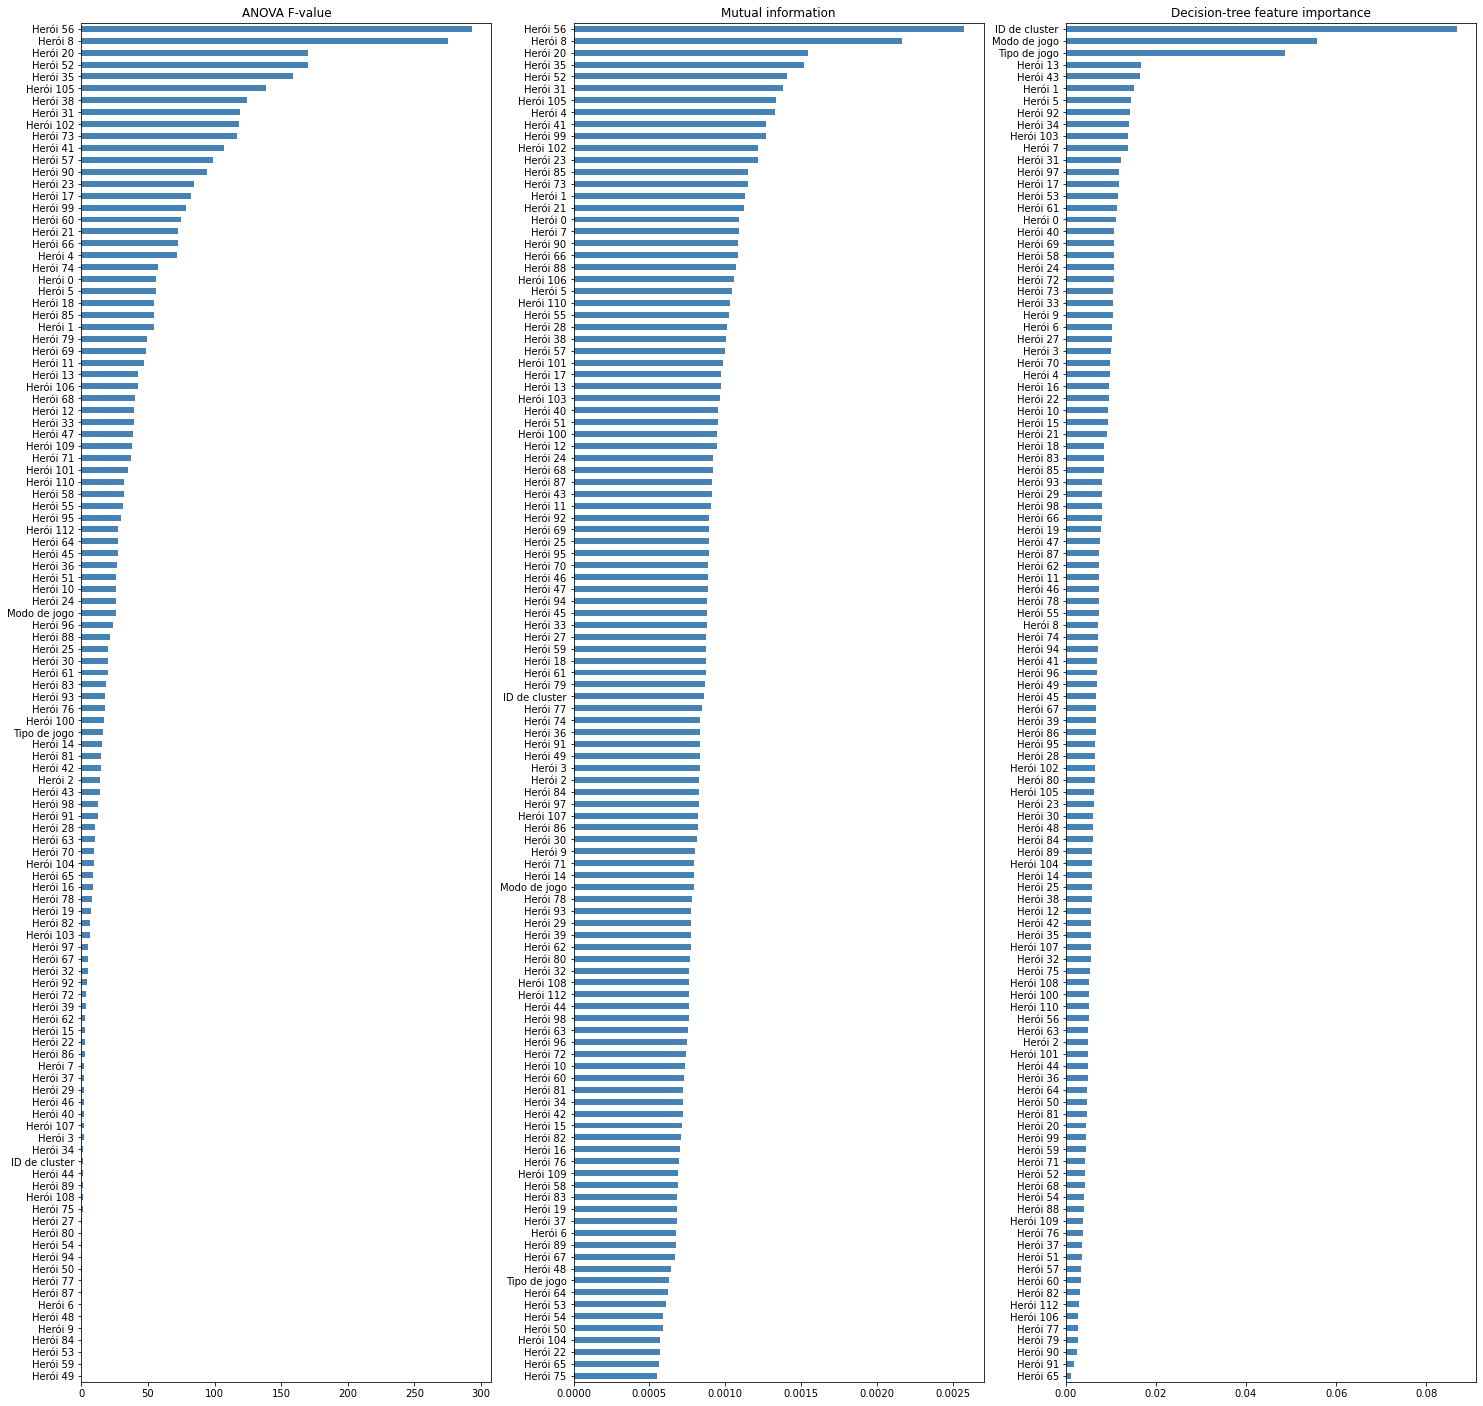

In [19]:
figura, eixos = plt.subplots(1, resultados_de_classificacao.shape[1], figsize=(25, 25), squeeze=True)

for indice, coluna in enumerate(resultados_de_classificacao.columns):
    resultados_de_classificacao.loc[:, coluna].sort_values().plot.barh(
        color="steelblue", title=coluna, ax=eixos.ravel()[indice]
    )
    
figura.savefig(f"{diretorio_de_resultados.as_posix()}/Classificações de características.jpg", transparent=False)

A figura acima nos permite observar algumas coisas. Em primeiro lugar, as dez características melhor correlacionadas são basicamente as mesmas entre `ANOVA F-value` e `Mutual information`. Contudo, a partir daí há uma significativa variação na ordem delas. Mesmo assim, nota-se que, ao contrário do observado em `Decision-tree feature importance`, as variáveis categóricas ocuparam as três primeiras posições. Qual desses três classificadores de características teria o melhor desempenho? Para além disso, qual número de características a ser utilizado seria o melhor?

In [20]:
def testa_conjuntos_de_caracteristicas(X, y, modelos, tamanhos, pontuacoes_de_classificacao, particionador, verboso=False):
    resultados = np.empty((0, 7), dtype=np.object_)

    for classificador in pontuacoes_de_classificacao.columns:
        pontuacoes = pontuacoes_de_classificacao.loc[:, classificador].to_numpy()
        indices_organizados = pontuacoes.argsort()[::-1]
        
        for tamanho in tamanhos:
            novo_X = X[:, indices_organizados[:tamanho]]

            for acronimo, modelo in modelos.items():
                if verboso is True:
                    print(f"[Tamanho = {tamanho}] Executando {acronimo.upper()}..." + 5 * " ", end="\r")
                
                if acronimo == "mlp":
                    instancia_do_modelo = modelo(hidden_layer_sizes=((novo_X.shape[1] + 1) // 2,), random_state=42)
                elif acronimo == "dt":
                    instancia_do_modelo = modelo()
                
                validacao_cruzada = model_selection.cross_validate(
                    instancia_do_modelo, novo_X, y, n_jobs=-1, cv=particionador, scoring=[
                        "accuracy", "f1"
                    ]
                )
                
                resultado = np.array([[
                    tamanho,
                    acronimo.upper(),
                    classificador,
                    validacao_cruzada["fit_time"].mean(),
                    validacao_cruzada["test_accuracy"].mean(),
                    validacao_cruzada["test_f1"].mean(),
                    np.array([
                        validacao_cruzada["test_accuracy"].mean(),
                        validacao_cruzada["test_f1"].mean()
                    ]).mean()
                ]])
                resultados = np.concatenate((resultados, resultado), axis=0)

    if verboso is True:
        print("Execução concluída." + 20 * " ")

    nomes_das_colunas = [
        "Tamanho",
        "Algoritmo",
        "Classificador de características",
        "Tempo médio de treino",
        "Acurácia média de teste",
        "Pontuação F1 média de teste",
        "Pontuação final"
    ]
        
    resultados = pd.DataFrame(resultados, columns=nomes_das_colunas)
    
    for coluna in nomes_das_colunas:
        if coluna not in nomes_das_colunas[1:3]:
            resultados.loc[:, coluna] = pd.to_numeric(resultados.loc[:, coluna])
    
    return resultados

A fim de responder a esta pergunta, é necessário gerar vários modelos e realizar a validação cruzada deles. Para isso, utilizaremos o `sklearn.model_selection.StratifiedKFold` para divisão do conjunto de dados de treino em 10 partes de forma que, a cada rodada, uma parte é utilizada como teste e as outras nove, como treino. Conforme o nome da classe expõe, essa divisão é feita de forma estratificada com base nos rótulos de classe do conjunto de treino.

Em termos do número de características a serem utilizados, os tamanhos $5$, $10$, $15$, $20$, $25$, $30$, $50$, $75$ e $114$ (todas as características) serão utilizados. Como ilustração, se o tamanho selecionado for 15 e o classificador de características escolhido for o `ANOVA F-value`, então as melhor correlacionadas 15 características de acordo com o `ANOVA F-value` serão escolhidas para compor o modelo, que será então validado de forma cruzada. A partir dessa validação, a acurácia e pontuação F1 médias serão obtidas, e uma pontuação final será criada a partir da média das duas medidas citadas.

Aqui, definiremos apenas o valor do parâmetro `hidden_layer_sizes` do `MLPClassifier` como sendo a média da quantidade de neurônios da camada de entrada e a da camada de saída, com apenas uma camada oculta. Também configuraremos uma semente por meio do parâmetro `random_state`. No que diz respeito ao `DecisionTreeClassifier`, deixaremos para testar valores de `max_depth` _a posteriori_.

In [21]:
particionador = model_selection.StratifiedKFold(n_splits=10)
tamanhos = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 114]

In [22]:
# resultados_de_validacao = testa_conjuntos_de_caracteristicas(
#     X_treino.to_numpy(), y_treino.to_numpy().ravel(), modelos, tamanhos, resultados_de_classificacao, particionador, verboso=True
# )
# resultados_de_validacao.to_csv(
#     f"{diretorio_de_resultados.as_posix()}/Medidas de modelos.csv", sep=";", index=False
# )

In [23]:
resultados_de_validacao = pd.read_csv(
    f"{diretorio_de_resultados.as_posix()}/Medidas de modelos.csv", sep=";", encoding="utf-8"
)
resultados_de_validacao.sort_values(by="Pontuação final", ascending=False).head(10)

,Tamanho,Algoritmo,Classificador de características,Tempo médio de treino,Acurácia média de teste,Pontuação F1 média de teste,Pontuação final
93,5,MLP,Decision-tree feature importance,5.924421,0.527227,0.686625,0.606926
11,30,MLP,ANOVA F-value,14.132098,0.582029,0.630411,0.606220
13,35,MLP,ANOVA F-value,14.055710,0.581946,0.627760,0.604853
7,20,MLP,ANOVA F-value,6.938958,0.577644,0.629779,0.603711
9,25,MLP,ANOVA F-value,8.287703,0.578948,0.627006,0.602977
15,40,MLP,ANOVA F-value,26.351353,0.580822,0.624812,0.602817
17,45,MLP,ANOVA F-value,30.289523,0.580031,0.624736,0.602383
19,50,MLP,ANOVA F-value,40.694392,0.581543,0.621702,0.601623
59,35,MLP,Mutual information,22.035570,0.577824,0.624435,0.601130
57,30,MLP,Mutual information,20.312732,0.578102,0.623967,0.601034


A tabela acima nos permite perceber que os melhores modelos tanto para a rede neural quanto para a árvore de decisão utilizaram apenas as $5$ características melhor correlacionadas. Para além disso, quando `Tamanho = 5` o uso tanto de `ANOVA F-value` quanto de `Mutual information` como classificadores de características gera resultados similares. Isso era esperado, considerando que as 5 características melhor pontuadas entre os dois classificadores eram praticamente as mesmas. Para esse conjunto de dados, se tivéssemos de optar por utilizar apenas um classificador de características, utilizaríamos o `ANOVA F-value`: embora o seu resultado se assemelhe, sob certa medida, ao obtido utilizando `Mutual information`, o `ANOVA F-value` é determinístico, o que faz com que os resultados possam ser obtidos muito mais rapidamente. Não por acaso, o `ANOVA F-value` é o classificador padrão utilizado pelo `sklearn.feature_selection.SelectKBest`.

In [24]:
print("Range da acurácia média de teste:     "
      f"[{resultados_de_validacao.loc[:, 'Acurácia média de teste'].min().round(4)}, "
      f"{resultados_de_validacao.loc[:, 'Acurácia média de teste'].max().round(4)}]\n"
      "Range da pontuação F1 média de teste: "
      f"[{resultados_de_validacao.loc[:, 'Pontuação F1 média de teste'].min().round(4)}, "
      f"{resultados_de_validacao.loc[:, 'Pontuação F1 média de teste'].max().round(4)}]\n"
      "Range da pontuação final:             "
      f"[{resultados_de_validacao.loc[:, 'Pontuação final'].min().round(4)}, "
      f"{resultados_de_validacao.loc[:, 'Pontuação final'].max().round(4)}]\n")

Range da acurácia média de teste:     [0.5007, 0.582]
Range da pontuação F1 média de teste: [0.5038, 0.6866]
Range da pontuação final:             [0.5023, 0.6069]



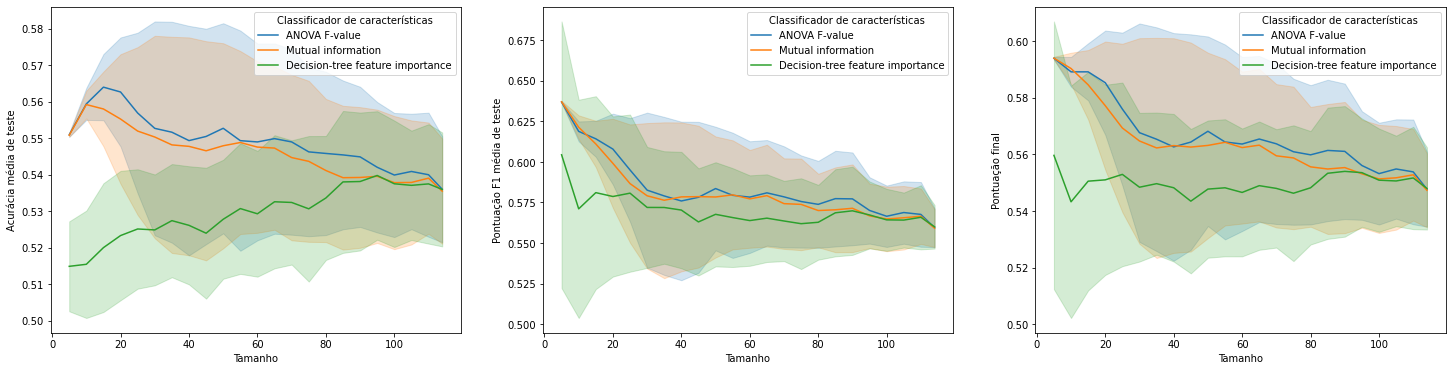

In [25]:
figura, eixos = plt.subplots(1, 3, figsize=(25, 6))

sns.lineplot(data=resultados_de_validacao, x="Tamanho", y="Acurácia média de teste", hue="Classificador de características", ax=eixos[0])
sns.lineplot(data=resultados_de_validacao, x="Tamanho", y="Pontuação F1 média de teste", hue="Classificador de características", ax=eixos[1])
sns.lineplot(data=resultados_de_validacao, x="Tamanho", y="Pontuação final", hue="Classificador de características", ax=eixos[2])

figura.savefig(f"{diretorio_de_resultados.as_posix()}/Informação dos modelos (por classificador).jpg", transparent=False)

A figura acima nos permite observar como o aumento no número de características utilizadas (a partir das listas ranqueadas geradas pelos classificadores de características) impacta a acurácia, a pontuação F1 e a pontuação final (i.e., a média entre a acurácia e a pontuação F1) dos modelos resultantes. Nota-se que, à exceção do classificador `Decision-tree feature importance`, a acurácia cai à medida em que o número de características aumenta. O comportamento exposto por `Decision-tree feature importance` causa estranhamento, e talvez signifique que ele não é um bom estimador da correlação das características com os rótulos de classe.

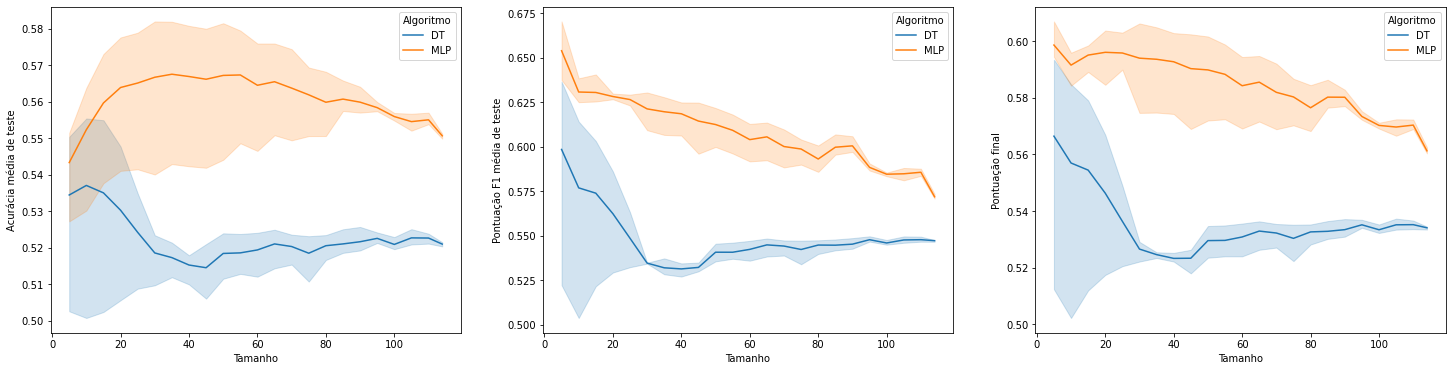

In [26]:
figura, eixos = plt.subplots(1, 3, figsize=(25, 6))

sns.lineplot(data=resultados_de_validacao, x="Tamanho", y="Acurácia média de teste", hue="Algoritmo", ax=eixos[0])
sns.lineplot(data=resultados_de_validacao, x="Tamanho", y="Pontuação F1 média de teste", hue="Algoritmo", ax=eixos[1])
sns.lineplot(data=resultados_de_validacao, x="Tamanho", y="Pontuação final", hue="Algoritmo", ax=eixos[2])

figura.savefig(f"{diretorio_de_resultados.as_posix()}/Informação dos modelos (por algoritmo).jpg", transparent=False)

A figura acima expõe as mesmas medidas da figura anterior, só que agrupadas por algoritmo de aprendizado de máquina ao invés de agrupadas por classificador. Percebe-se por meio dela que há números de características ótimos diferentes para cada algoritmo: para a árvore de decisão, o melhor tamanho aparenta ser por volta de K = 10. No caso da rede neural, o melhor seria algo como K = 30.

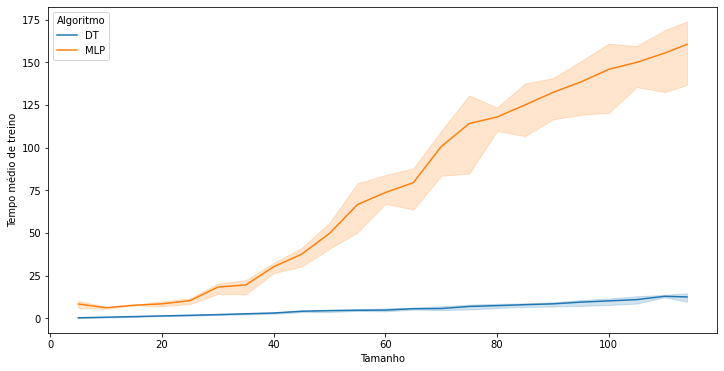

In [27]:
figura, eixo = plt.subplots(1, 1, figsize=(12, 6))

sns.lineplot(data=resultados_de_validacao, x="Tamanho", y="Tempo médio de treino", hue="Algoritmo", ax=eixo)

figura.savefig(f"{diretorio_de_resultados.as_posix()}/Tendência do tempo de treinamento.jpg", transparent=False)

Por fim, a figura acima nos permite observar como o aumento no número de características impacta o tempo de treinamento dos dois algoritmos utilizados. Tem-se que é muito mais custoso treinar uma rede neural do que uma árvore de decisão, o que já era esperado. Contudo, considerando o quão similares os resultados foram em termos das medidas coletadas, tem-se que é mais vantajoso aqui utilizar a árvore de decisão do que a rede neural.

Considerando os dados expostos acima, as seguintes decisões serão feitas:

- O classificador de características `ANOVA F-value` será utilizado doravante.
- Para a árvore de decisão, as 10 características melhor correlacionadas serão utilizadas.
- Para a rede neural, as 30 características melhor correlacionadas serão utilizadas.

## Definição do melhor valor de `max_depth` para a árvore de decisão

Sabe-se que, com os valores-padrão da implementação do `scikit-learn` da árvore de decisão, há uma tendência de que ocorra _overfitting_. De forma a visualizar se esse é o caso, vejamos como a árvore se encontra no momento.

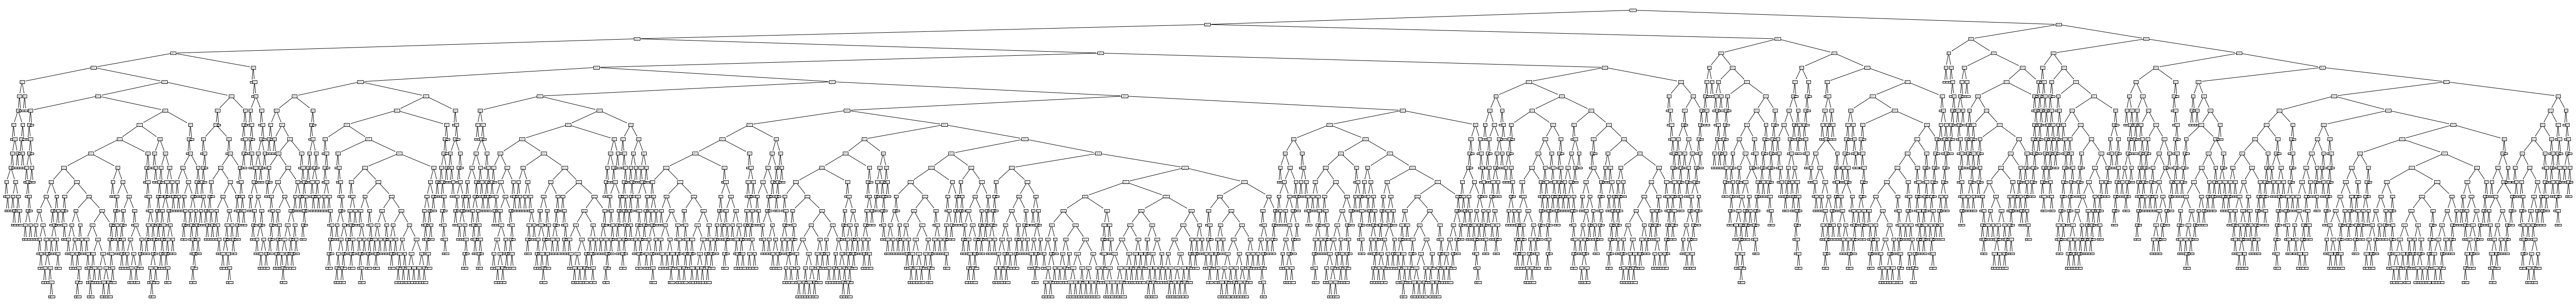

In [28]:
pontuacoes = resultados_de_classificacao.loc[:, "ANOVA F-value"].to_numpy()
indices_organizados = pontuacoes.argsort()[::-1]

figura, eixo = plt.subplots(1, 1, figsize=(100, 12))

arvore_de_decisao = tree.DecisionTreeClassifier()
arvore_de_decisao.fit(X_treino.to_numpy()[:, indices_organizados[:10]], y_treino.to_numpy())

tree.plot_tree(arvore_de_decisao, ax=eixo)

figura.savefig(f"{diretorio_de_resultados.as_posix()}/Árvore de decisão (max_depth padrão).pdf", transparent=False)

Como se pode ver, há um claro _overfitting_ da árvore, sobretudo se considerarmos que há apenas 10 características sendo levadas em conta aqui. Vejamos qual o valor de `max_depth` atual da árvore.

In [29]:
arvore_de_decisao.tree_.max_depth

20

Agora, vejamos como melhorar esse equilíbrio entre `max_depth` e acurácia.

In [30]:
def testa_profundidade_maxima_da_arvore(X, y, profundidades, particionador, verboso=False):
    resultados = np.empty((0, 5), dtype=np.object_)

    for profundidade in profundidades:
        if verboso is True:
            print(f"[Profundidade = {profundidade}] Executando DT..." + 5 * " ", end="\r")

        validacao_cruzada = model_selection.cross_validate(
            tree.DecisionTreeClassifier(max_depth=profundidade), X, y, n_jobs=-1, cv=particionador, scoring=[
                "accuracy", "f1"
            ]
        )

        resultado = np.array([[
            profundidade,
            validacao_cruzada["fit_time"].mean(),
            validacao_cruzada["test_accuracy"].mean(),
            validacao_cruzada["test_f1"].mean(),
            np.array([
                validacao_cruzada["test_accuracy"].mean(),
                validacao_cruzada["test_f1"].mean()
            ]).mean()
        ]])
        resultados = np.concatenate((resultados, resultado), axis=0)

    if verboso is True:
        print("Execução concluída." + 20 * " ")

    nomes_das_colunas = [
        "Profundidade máxima",
        "Tempo médio de treino",
        "Acurácia média de teste",
        "Pontuação F1 média de teste",
        "Pontuação final"
    ]
        
    resultados = pd.DataFrame(resultados, columns=nomes_das_colunas)
    
    for coluna in nomes_das_colunas:
        if coluna not in nomes_das_colunas[1:3]:
            resultados.loc[:, coluna] = pd.to_numeric(resultados.loc[:, coluna])
    
    return resultados

Testaremos todas as profundidades no intervalo [1, 20], e visualizaremos como a acurácia, a pontuação F1 e a pontuação final resultante a partir delas evolui à medida em que `max_depth` aumenta.

In [31]:
# pontuacoes = resultados_de_classificacao.loc[:, "ANOVA F-value"].to_numpy()
# indices_organizados = pontuacoes.argsort()[::-1]
# 
# resultados_de_profundidade_de_arvore = testa_profundidade_maxima_da_arvore(
#     X_treino.to_numpy()[:, indices_organizados[:10]], y_treino.to_numpy(), range(1, 21), particionador, verboso=True
# )
# resultados_de_profundidade_de_arvore.to_csv(
#     f"{diretorio_de_resultados.as_posix()}/Resultados de profundidade de árvore.csv", sep=";", index=False
# )

In [32]:
resultados_de_profundidade_de_arvore = pd.read_csv(
    f"{diretorio_de_resultados.as_posix()}/Resultados de profundidade de árvore.csv", sep=";", encoding="utf-8"
)
resultados_de_profundidade_de_arvore.sort_values(by="Pontuação final", ascending=False).head(10)

,Profundidade máxima,Tempo médio de treino,Acurácia média de teste,Pontuação F1 média de teste,Pontuação final
3,4.0,0.224683,0.538565,0.679972,0.609269
0,1.0,0.067100,0.527311,0.690509,0.608910
2,3.0,0.181505,0.533264,0.684495,0.608879
1,2.0,0.152402,0.527893,0.688678,0.608286
4,5.0,0.210197,0.540661,0.675389,0.608025
5,6.0,0.236697,0.543616,0.671285,0.607451
6,7.0,0.283802,0.545309,0.665670,0.605490
7,8.0,0.325604,0.547252,0.660107,0.603680
8,9.0,0.327214,0.547655,0.655436,0.601546
9,10.0,0.359294,0.548043,0.652691,0.600367


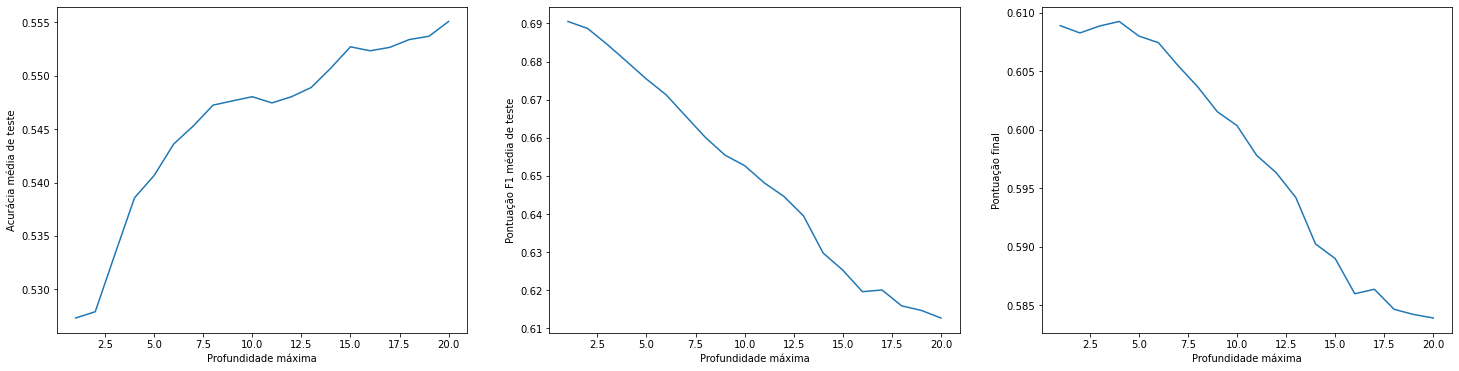

In [33]:
figura, eixos = plt.subplots(1, 3, figsize=(25, 6))

sns.lineplot(data=resultados_de_profundidade_de_arvore, x="Profundidade máxima", y="Acurácia média de teste", ax=eixos[0])
sns.lineplot(data=resultados_de_profundidade_de_arvore, x="Profundidade máxima", y="Pontuação F1 média de teste", ax=eixos[1])
sns.lineplot(data=resultados_de_profundidade_de_arvore, x="Profundidade máxima", y="Pontuação final", ax=eixos[2])

figura.savefig(f"{diretorio_de_resultados.as_posix()}/Evolução da acurácia da árvore (por profundidade).jpg", transparent=False)

Testemos como a árvore fica quando a profundidade máxima é igual a 3 e a 8.

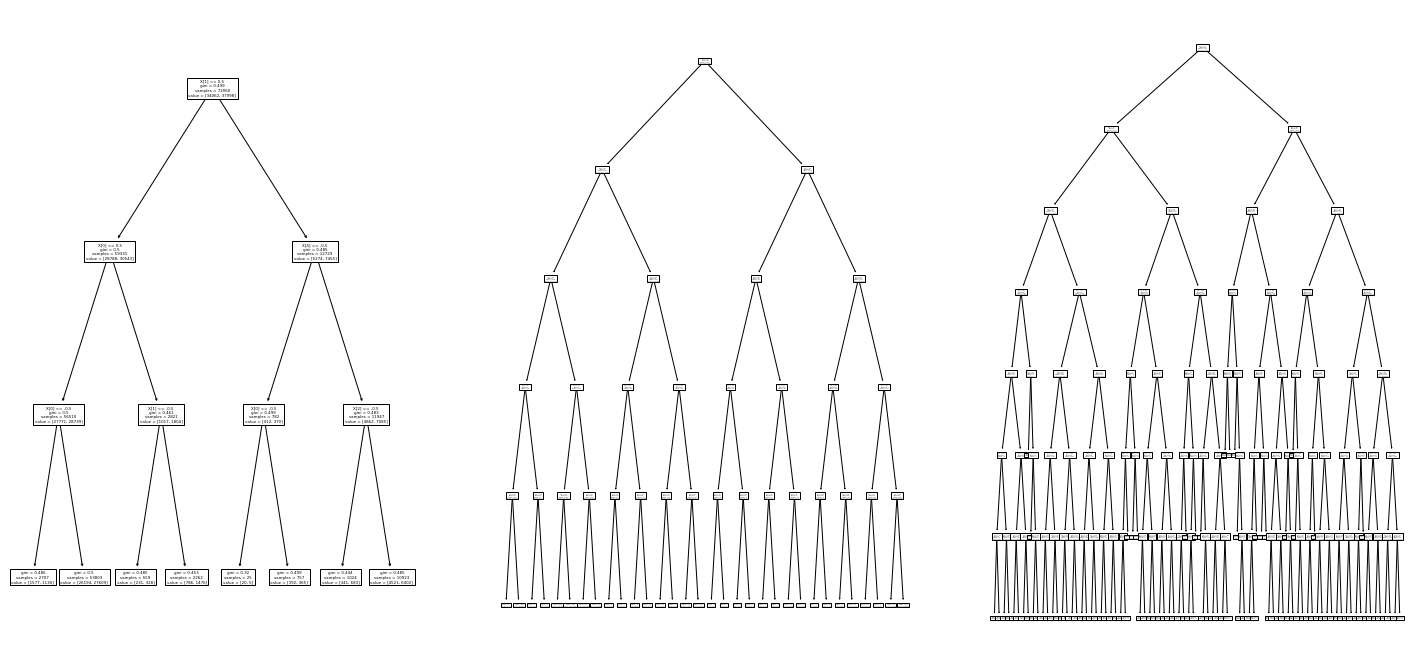

In [34]:
figura, eixos = plt.subplots(1, 3, figsize=(25, 12))

for eixo, profundidade in enumerate([3, 5, 7]):
    arvore_de_decisao = tree.DecisionTreeClassifier(max_depth=profundidade)
    arvore_de_decisao.fit(X_treino.to_numpy()[:, indices_organizados[:10]], y_treino.to_numpy())

    tree.plot_tree(arvore_de_decisao, ax=eixos[eixo])

figura.savefig(f"{diretorio_de_resultados.as_posix()}/Árvore de decisão (max_depth igual a 3, 5 e 7).pdf", transparent=False)

Considerando o número de características, estipula-se como razoável adotar `max_depth = 3`.

# Processamento

## Modelo _baseline_

Para este caso, em que temos uma classificação binária, tem-se que o modelo _baseline_ para este conjunto de dados seria prever sempre o rótulo que mais aparece.

In [35]:
contagem_de_rotulos_treino = y_treino.value_counts()
contagem_de_rotulos_treino

Vencedor
 1          37998
-1          34062
dtype: int64

In [36]:
contagem_de_rotulos_teste = y_teste.value_counts()
contagem_de_rotulos_teste

Vencedor
 1          16286
-1          14598
dtype: int64

Para o conjunto de dados de treino, a moda dos rótulos de classe é 1. Vejamos qual seria a acurácia do modelo _baseline_ no conjunto de treino.

In [37]:
contagem_de_rotulos_treino.iloc[0] / contagem_de_rotulos_treino.sum()

0.5273105745212323

Agora, façamos o mesmo no conjunto de teste.

In [38]:
contagem_de_rotulos_teste.iloc[0] / contagem_de_rotulos_teste.sum()

0.5273280663126538

Dessa forma, tem-se que a acurácia-base do modelo _baseline_ construído no conjunto de treino (i.e., sempre predizer $1$) no conjunto de teste é de $52,7\%$.

Uma observação certamente mais desanimadora é que tanto a pontuação F1 quanto a acurácia não superaram em muito o modelo _baseline_ de $52,7\%$, mesmo após várias tentativas de seleção de características, conforme visto anteriormente. Embora não tenhamos tentado refinar os hiper-parâmetros dos algoritmos de aprendizado de máquina, é seguro afirmar que este conjunto de dados deixa a desejar em termos de características descritas.

## Modelos construídos

In [39]:
def gera_resultados(X, y, modelos, tamanho, pontuacoes_de_classificacao, classificador, verboso=False, execucoes=10):
    bases = ["Base de treino", "Base de teste", "Base completa"]
    iteracoes = list(range(execucoes))
    
    algoritmos = [acronimo.upper() for acronimo in modelos.keys()]
    nomes_das_medidas = [
        "Matriz de confusão", "Sensibilidade", "Especificidade", "Confiabilidade positiva", "Confiabilidade negativa", "Acurácia"
    ]
    
    nomes_das_linhas = pd.MultiIndex.from_product((bases, iteracoes), names=["Base", "Execução"])
    nomes_das_colunas = pd.MultiIndex.from_product((algoritmos, nomes_das_medidas), names=["Algoritmo", "Medida"])

    resultados = pd.DataFrame(index=nomes_das_linhas, columns=nomes_das_colunas)
    
    for i in range(execucoes):
        dados = gera_dados(X, y, tamanho, pontuacoes_de_classificacao, classificador, semente=i)
        X_filtrado, y_filtrado, X_treino, X_teste, y_treino, y_teste = dados
        
        modelos_treinados = treina_modelos(X_treino, y_treino, modelos, verboso=verboso, semente=i)
        
        dados = {"Base de treino": X_treino, "Base de teste": X_teste, "Base completa": X_filtrado}
        rotulos = {"Base de treino": y_treino, "Base de teste": y_teste, "Base completa": y_filtrado}
        
        for acronimo, modelo_treinado in modelos_treinados.items():            
            for base in bases:
                y_pred = modelo_treinado.predict(dados[base])
                
                matriz_de_confusao = metrics.confusion_matrix(rotulos[base], y_pred)
                verdadeiro_negativo, falso_positivo, falso_negativo, verdadeiro_positivo = matriz_de_confusao.ravel()
                
                sensibilidade = verdadeiro_positivo / (verdadeiro_positivo + falso_negativo)
                especificidade = verdadeiro_negativo / (verdadeiro_negativo + falso_positivo)
                confiabilidade_positiva = verdadeiro_positivo / (verdadeiro_positivo + falso_positivo)
                confiabilidade_negativa = verdadeiro_negativo / (verdadeiro_negativo + falso_negativo)
                acuracia = metrics.accuracy_score(rotulos[base], y_pred)
                
                medidas = np.array(
                    [sensibilidade, especificidade, confiabilidade_positiva, confiabilidade_negativa, acuracia]
                )
                
                resultados.loc[
                    (base, i), (acronimo.upper(), "Matriz de confusão")
                ] = str(matriz_de_confusao).replace("\n", ",").replace("[ ", "[")
                resultados.loc[
                    (base, i), (acronimo.upper(), nomes_das_medidas[1:])
                ] = medidas
                
            for nome_da_medida in nomes_das_medidas[1:]:
                resultados.loc[:, (acronimo.upper(), nome_da_medida)] = pd.to_numeric(
                    resultados.loc[:, (acronimo.upper(), nome_da_medida)]
                )
        
    return resultados

In [40]:
def gera_dados(X, y, tamanho, pontuacoes_de_classificacao, classificador, semente=None):
    pontuacoes = pontuacoes_de_classificacao.loc[:, classificador].to_numpy()
    indices_organizados = pontuacoes.argsort()[::-1]
    
    X_filtrado = X.iloc[:, indices_organizados[:tamanho]].copy()
    
    X_treino, X_teste, y_treino, y_teste = model_selection.train_test_split(
        X_filtrado, y, test_size=0.3, random_state=semente, stratify=y
    )
    X_treino, X_teste, y_treino, y_teste = X_treino.copy(), X_teste.copy(), y_treino.copy(), y_teste.copy()

    codificador_de_rotulo = KFoldStratifiedTargetEncoder(number_of_folds=10)

    X_treino.iloc[:, 0:3] = codificador_de_rotulo.fit_transform(
        X_treino.iloc[:, 0:3].to_numpy(), y_treino.to_numpy().ravel()
    )
    X_teste.iloc[:, 0:3] = codificador_de_rotulo.transform(X_teste.iloc[:, 0:3].to_numpy())

    X_treino, y_treino = X_treino.to_numpy(), y_treino.to_numpy().ravel()
    X_teste, y_teste = X_teste.to_numpy(), y_teste.to_numpy().ravel()
    
    return X_filtrado.to_numpy(), y.to_numpy().ravel(), X_treino, X_teste, y_treino, y_teste

In [41]:
def treina_modelos(X, y, modelos, verboso=False, semente=None):
    instancias_de_modelos = {}
    for acronimo, classe in modelos.items():
        if verboso is True:
            print(f"Executando {acronimo.upper()}..." + 5 * " ", end="\r")
        
        if acronimo == "mlp":
            modelo = classe(hidden_layer_sizes=((X.shape[1] + 1) // 2,), random_state=semente)
        elif acronimo == "dt":
            modelo = classe(max_depth=3)
        
        modelo.fit(X, y)
        instancias_de_modelos[acronimo] = modelo

    if verboso is True:
        print("Execução concluída." + 20 * " ")
    
    return instancias_de_modelos

Uma vez decididos os aspectos importantes do modelo a ser construído, é hora de sua construção propriamente dita e coleta das medidas especificicadas no trabalho.

In [42]:
# resultados_de_teste = gera_resultados(X, y, modelos, 5, resultados_de_classificacao, "ANOVA F-value")
# resultados_de_teste.to_csv(
#     f"{diretorio_de_resultados.as_posix()}/Resultados de teste.csv", sep=";"
# )

In [43]:
resultados_de_teste = pd.read_csv(f"{diretorio_de_resultados.as_posix()}/Resultados de teste.csv", sep=";", index_col=[0, 1], header=[0, 1])
resultados_de_teste

Algoritmo                                          DT                \
Medida                             Matriz de confusão Sensibilidade   
Base           Execução                                               
Base de treino 0         [[1846 32216], [1331 36667]]      0.964972   
               1         [[1798 32264], [1283 36715]]      0.966235   
               2         [[1942 32120], [1458 36540]]      0.961630   
               3         [[2201 31861], [1733 36265]]      0.954392   
               4         [[1942 32120], [1481 36517]]      0.961024   
               5         [[ 658 33404], [ 630 37368]]      0.983420   
               6         [[2222 31840], [1718 36280]]      0.954787   
               7         [[ 668 33394], [ 627 37371]]      0.983499   
               8         [[1958 32104], [1430 36568]]      0.962366   
               9         [[1928 32134], [1490 36508]]      0.960787   
Base de teste  0         [[ 753 13845], [ 607 15679]]      0.962729   
               1         [[ 701 13897], [ 575 15711]]      0.964694   
               2         [[ 795 13803], [ 608 15678]]      0.962667   
               3         [[ 892 13706], [ 736 15550]]      0.954808   
               4         [[ 825 13773], [ 630 15656]]      0.961316   
               5         [[ 272 14326], [ 267 16019]]      0.983606   
               6         [[ 876 13722], [ 770 15516]]      0.952720   
               7         [[ 262 14336], [ 270 16016]]      0.983421   
               8         [[ 800 13798], [ 658 15628]]      0.959597   
               9         [[ 801 13797], [ 638 15648]]      0.960825   
Base completa  0         [[2604 46056], [1944 52340]]      0.964188   
               1         [[2496 46164], [1858 52426]]      0.965773   
               2         [[2731 45929], [2082 52202]]      0.961646   
               3         [[3093 45567], [2469 51815]]      0.954517   
               4         [[2767 45893], [2111 52173]]      0.961112   
               5         [[ 930 47730], [ 897 53387]]      0.983476   
               6         [[3098 45562], [2488 51796]]      0.954167   
               7         [[ 930 47730], [ 897 53387]]      0.983476   
               8         [[2756 45904], [2099 52185]]      0.961333   
               9         [[2729 45931], [2128 52156]]      0.960799   

Algoritmo                                                       \
Medida                  Especificidade Confiabilidade positiva   
Base           Execução                                          
Base de treino 0              0.054195                0.532308   
               1              0.052786                0.532263   
               2              0.057014                0.532188   
               3              0.064617                0.532322   
               4              0.057014                0.532031   
               5              0.019318                0.528005   
               6              0.065234                0.532590   
               7              0.019611                0.528100   
               8              0.057483                0.532502   
               9              0.056603                0.531861   
Base de teste  0              0.051582                0.531059   
               1              0.048020                0.530634   
               2              0.054460                0.531800   
               3              0.061104                0.531515   
               4              0.056515                0.531992   
               5              0.018633                0.527896   
               6              0.060008                0.530679   
               7              0.017948                0.527675   
               8              0.054802                0.531095   
               9              0.054871                0.531431   
Base completa  0              0.053514                0.531932   
               1              0.051295                0.531758   
      

In [44]:
def obtem_medida_media(resultados_de_teste, medida, modelos):
    nomes_das_linhas = ["Base de treino", "Base de teste", "Base completa"]
    nomes_das_colunas = [nome.upper() for nome in modelos.keys()]

    media = resultados_de_teste.xs(medida, axis=1, level=1).groupby("Base").mean().to_numpy()
    desvio_padrao = resultados_de_teste.xs(medida, axis=1, level=1).groupby("Base").std().to_numpy()

    medida_media = pd.DataFrame(
        index=nomes_das_linhas, columns=nomes_das_colunas, dtype=np.object_
    )

    medida_media.index.name = "Base"
    medida_media.columns.name = "Algoritmos"

    for l in range(len(nomes_das_linhas)):
        for c in range(len(nomes_das_colunas)):
            str_media = str((media[l, c] * 100).round(3)).ljust(5, "0")
            str_desvio_padrao = str((desvio_padrao[l, c] * 100).round(3)).ljust(5, "0")
            medida_media.iloc[l, c] = f"{str_media}% ± {str_desvio_padrao}%"
            
    return medida_media

Em particular, vejamos os valores médios de acurácia para os dois algoritmos considerados.

In [45]:
acuracia_media = obtem_medida_media(resultados_de_teste, "Acurácia", modelos)
acuracia_media

Algoritmos,DT,MLP
Base,,
Base de treino,53.233% ± 0.248%,51.325% ± 0.204%
Base de teste,53.127% ± 0.227%,55.202% ± 0.231%
Base completa,53.284% ± 0.269%,55.209% ± 0.093%


Observa-se aqui que, em condizência com o visto na etapa de seleção de características, a acurácia de teste infelizmente não supera em muito o modelo _baseline_. Também em consonância com o visto anteriormente, a acurácia da rede neural produzida é similar à da árvore de decisão construída. Considerando que o tempo de treinamento da rede neural é consideravelmente maior do que o da árvore de decisão, tem-se que o melhor algoritmo em geral para lidar com este conjunto de dados é a árvore de decisão.

Outras técnicas poderiam ser testadas na tentativa de melhorar a acurácia, como substituir a seleção de características por extração de características através de técnicas de redução de dimensionalidade _embedding-based_. Contudo, considerando as informações contidas no conjunto de dados analisado e com base no que se sabe acerca do contexto do problema, tem-se que o problema maior é o de informações ausentes acerca da partida, como quantidade de ouro coletada, mortes, assassinatos, assistências, tempo de partida, entre outros. Dessa forma, a despeito dos modelos produzidos possuírem capacidade preditiva aquém do esperado, opta-se por encerrar a análise aqui, na esperança de total aderência com as especificações expostas no documento descritivo deste trabalho.